<a href="https://colab.research.google.com/github/SvetlanaRubina/histopathology-slides-unsupervised-learning/blob/main/Unsupervised_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pangea Biomed - AI researcher Home Assignment


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.transforms import ToTensor

from PIL import Image
from sklearn.cluster import KMeans
import random

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


### Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, is_test=False):
        self.root_folder = root_folder
        self.transform = transform
        self.is_test = is_test

        self.image_paths = []
        self.file_names = []  # Store file names instead of full paths
        self.labels = []

        if not is_test:
            # For the unlabeled training dataset
            for filename in os.listdir(root_folder):
                img_path = os.path.join(root_folder, filename)
                self.image_paths.append(img_path)
                self.file_names.append(filename)  # Store file names
        else:
            # For the labeled test dataset
            class_folders = os.listdir(root_folder)
            for class_folder in class_folders:
                class_path = os.path.join(root_folder, class_folder)
                if class_folder == 'class_a':
                    label = 0
                elif class_folder == 'class_b':
                    label = 1
                else:
                    continue

                for filename in os.listdir(class_path):
                    img_path = os.path.join(class_path, filename)
                    self.image_paths.append(img_path)
                    self.file_names.append(filename)  # Store file names
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            label = self.labels[idx]
            file_name = self.file_names[idx]
            return image, label, file_name
        else:
            file_name = self.file_names[idx]
            return image

In [4]:
means = [0.485, 0.456, 0.406] # for ImageNet only!
stds = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=means, std=stds)
])

In [5]:
train_dataset_path = '/content/gdrive/MyDrive/TCGA_Dataset/ver1/train'
test_dataset_path = '/content/gdrive/MyDrive/TCGA_Dataset/ver1/test'

train_dataset = CustomDataset(root_folder=train_dataset_path, transform=data_transforms)
test_dataset = CustomDataset(root_folder=test_dataset_path, transform=data_transforms, is_test=True)

batch_size = 16

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)


### Data Visualization

In [47]:
# A helper function to show an image from a tensor
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(means)
    std = np.array(stds)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)

In [48]:
inputs_class_a = [test_dataset[i][0] for i in range (0,40,4)]
inputs_class_b = [test_dataset[i][0] for i in range (60,100,4)]

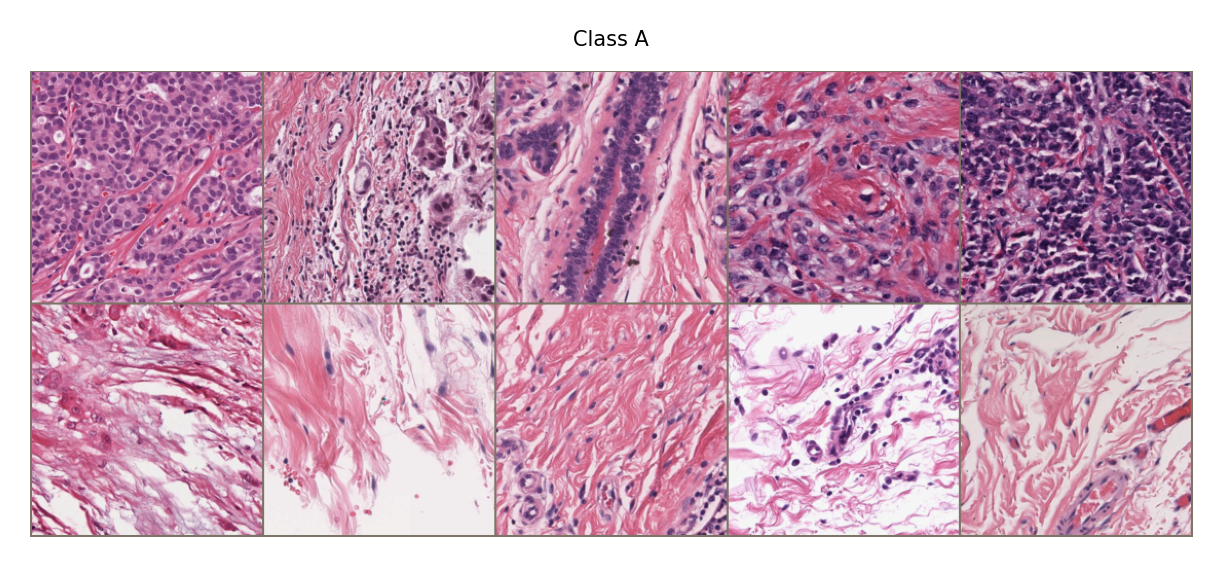

In [49]:
out = torchvision.utils.make_grid(inputs_class_a, nrow=5)
imshow(out, title = "Class A")

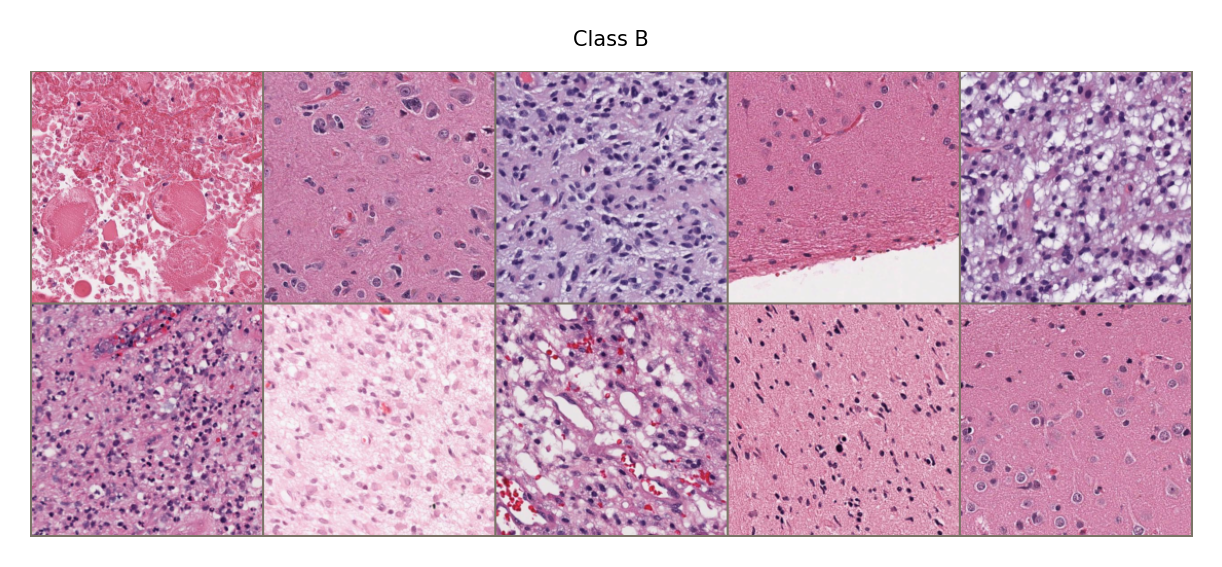

In [50]:
out = torchvision.utils.make_grid(inputs_class_b, nrow=5)
imshow(out, title = "Class B")

### Uploading a Pre-trained VGG16 Model

In [7]:
vgg16 = models.vgg16(pretrained=True)
modules = list(vgg16.children())[:-1]
vgg16 = nn.Sequential(*modules)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Uploading a Simple Autoencoder

In [8]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

In [9]:
def extract_features(image_loader, model, is_test = False):
    model.eval()
    features_list = []
    labels_list = []
    file_names = []
    with torch.no_grad():
        for batch in image_loader:
          features = model(batch[0]) if is_test else model(batch)
          features = features.view(features.size(0), -1)
          features_list.extend(features.cpu().numpy())
          if is_test:
            labels_list.extend(batch[1].cpu().numpy())
            file_names.extend(batch[2])
            #print(file_names)
    if is_test:
        return np.array(features_list), np.array(labels_list), np.array(file_names)
    else:
        return np.array(features_list)

In [10]:
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

features_train = extract_features(train_loader, vgg16)
cluster_labels = kmeans.fit_predict(features_train)
cluster_to_class_mapping = {cluster: np.argmax(np.bincount(cluster_labels[cluster_labels == cluster]))
                            for cluster in range(num_clusters)}

features_test, test_labels, file_names = extract_features(test_loader, vgg16, is_test = True)
cluster_labels_test = kmeans.fit_predict(features_test)
cluster_to_class_mapping_test = {cluster: np.argmax(np.bincount(test_labels[cluster_labels_test == cluster]))
                                for cluster in range(num_clusters)}
predicted_labels_test = [cluster_to_class_mapping_test[cluster] for cluster in cluster_labels_test]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [12]:
from sklearn.metrics import accuracy_score
score = accuracy_score(test_labels, predicted_labels_test)
print ('Accuracy_score=', score)
print('PRFS=', precision_recall_fscore_support(test_labels, predicted_labels_test, average='weighted'))

Accuracy_score= 0.97
PRFS= (0.9716981132075472, 0.97, 0.9699729756781104, None)


### Visualizing the Model Predictions

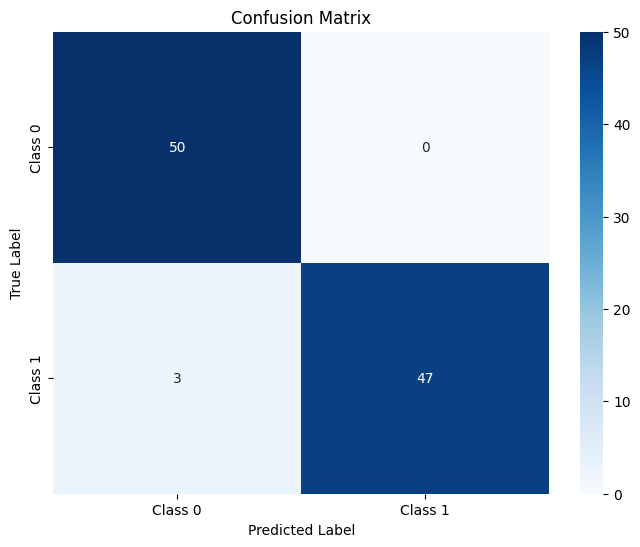

In [13]:
confusion_mat = confusion_matrix(test_labels, predicted_labels_test)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Saving the Results

In [20]:
# Save the single-column NumPy array into a CSV file
test_results = list(zip(file_names, predicted_labels_test))
np.savetxt('output.csv', test_results, delimiter=',', fmt='%s', header='<file_name>,<class>', comments='')